In [ ]:
from collections import defaultdict
import io

import torch
from torch.utils.data import DataLoader

from compressai import zoo

import torchmetrics as tm
import torchmetrics.functional as tmF

import neuralcompression as nc
import neuralcompression.functional as ncF
import neuralcompression.metrics as ncm

import torchvision.transforms as tfms
import numpy as np

from tqdm import tqdm

import math
from PIL import Image

import matplotlib.pyplot as plt

Using /home/babakov/.cache/torch_extensions/py38_cu102 as PyTorch extensions root...
Emitting ninja build file /home/babakov/.cache/torch_extensions/py38_cu102/_pmf_to_quantized_cdf/build.ninja...
Building extension module _pmf_to_quantized_cdf...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module _pmf_to_quantized_cdf...


# Data

In [2]:
from NeuralCompression.neuralcompression.data._kodak import Kodak

In [22]:
# Pass download=True if dataset doesn't exist already
ds = Kodak("kodak", transform = tfms.ToTensor())
dl = DataLoader(ds, batch_size = 1)

for i, img in enumerate(dl):   
    print(img.shape)
    break

torch.Size([1, 3, 512, 768])


# CP

In [4]:
# http://tensorly.org/stable/auto_examples/decomposition/plot_image_compression.html#sphx-glr-auto-examples-decomposition-plot-image-compression-py

In [5]:
import matplotlib.pyplot as plt
import tensorly as tl
import numpy as np
from scipy.misc import face
from scipy.ndimage import zoom
from tensorly.decomposition import parafac
from tensorly.decomposition import tucker
from math import ceil

from tensorly.decomposition import matrix_product_state
from tensorly import tt_to_tensor

In [6]:
def to_image(tensor):
    """A convenience function to convert from a float dtype back to uint8"""
    im = tl.to_numpy(tensor)
    im -= im.min()
    im /= im.max()
    im *= 255
    return im.astype(np.uint8)

In [7]:
metrics = tm.MetricCollection(
    tm.PSNR(), 
    tm.MeanSquaredError(), 
    ncm.MultiscaleStructuralSimilarity()#
)

/home/babakov/.local/lib/python3.8/site-packages/deprecate/deprecation.py:115: FutureWarning: The `PSNR` was deprecated since v0.7 in favor of `torchmetrics.image.psnr.PeakSignalNoiseRatio`. It will be removed in v0.8.
  stream(template_mgs % msg_args)


In [29]:
for rank in range(4,22,4):
    print(rank)

4
8
12
16
20


In [51]:
def make_rd_curve(dataloader, dec_type, metrics: tm.MetricCollection):
    rd_curve = []
    to_tensor = tfms.ToTensor()
    
    random_state = 12345
    
    if dec_type == 'cp':
        tq = tqdm(range(1,5,2))
    elif dec_type == 'tucker':
        tq = tqdm(range(2,20,4))
    elif dec_type == 'tt':
        tq = tqdm(range(4,13,2))
        
    for rank in tq:
        
        bpp_sum = 0.0
        metrics_sum = defaultdict(lambda: 0.0)

        for i, img in enumerate(dataloader):     
            
            img = tl.tensor(img, dtype='float32')
            
            if dec_type == 'cp':
                weights, factors = parafac(img, rank=rank, init='random', tol=10e-6)
                # Reconstruct the image from the factors
                reconstruction = tl.cp_to_tensor((weights, factors))    
                bpp = sum([np.prod(param.shape) for param in [weights] + factors]) * 32 / img.shape[2] / img.shape[3]
            elif dec_type == 'tucker':
                tucker_rank = [rank] * 4
                weights, factors = tucker(img, rank=tucker_rank, init='random', tol=10e-5, random_state=random_state)
                reconstruction = tl.tucker_to_tensor((weights, factors))
                bpp = sum([np.prod(param.shape) for param in [weights] + factors]) * 32 / img.shape[2] / img.shape[3]
            elif dec_type == 'tt':
                # Tucker decomposition
                rank_list = [1] + [rank] * 3 + [1]
                factors = matrix_product_state(img, rank=rank_list)
                reconstruction = tt_to_tensor(factors)
                bpp = sum([np.prod(param.shape) for param in factors]) * 32 / img.shape[2] / img.shape[3]
            
            # print(img.shape)
            # print(bpp)

            bpp_sum += bpp
            
            if dec_type == 'cp':
                img = torch.tensor(img)
                reconstruction = torch.tensor(reconstruction)
            else:
                img = torch.tensor(img).double()
                reconstruction = torch.tensor(reconstruction).double()

            distortions = metrics(img, reconstruction)
            for k,v in distortions.items():
                metrics_sum[k] += v
                
#             raise Exception("STOP")
#             if i == 2: break

        average_metrics = {k: v / len(dataloader) for k,v in metrics_sum.items()}
        average_bpp = bpp_sum / len(dataloader)
        rd_curve.append((average_bpp, average_metrics))
        
        # break

    return rd_curve

cp_curve = make_rd_curve(dl, 'cp', metrics)









  0%|          | 0/2 [00:00<?, ?it/s]







 50%|█████     | 1/2 [00:40<00:40, 40.21s/it]







100%|██████████| 2/2 [02:11<00:00, 65.76s/it]


In [52]:
# torch.save(cp_curve, 'cp.pt')
torch.save(cp_curve, 'cp_prev.pt')

In [53]:
cp_curve_1 = torch.load('cp_prev.pt')
cp_curve_2 = torch.load('cp.pt')
cp_curve = cp_curve_1[1:] + cp_curve_2

In [41]:
tucker_curve = torch.load('tuckercurve.pt')

In [63]:
tt_curve_1 = torch.load('tt_curve_prev.pt')
tt_curve_2 = torch.load('tt_curve.pt')
tt_curve = tt_curve_1 + tt_curve_2

# Plot

In [65]:
def plot_rd_curve(names_to_rd_curves, metric_name, y_label = None, y_transform = None):       
    plot = plt.axes()

    plot.set_title(f"{metric_name} vs bits-per-pixel")
    plot.set_xlabel("bits per pixel")
    
    if y_label is None:
        plot.set_ylabel(metric_name)
    else:
        plot.set_ylabel(y_label)
        
    for codec_name, curve in names_to_rd_curves.items():
        x_data = [data[0] for data in curve]
        y_data = [data[1][metric_name] for data in curve]
            
        if y_transform is not None:
            y_data = [y_transform(y) for y in y_data]
        
        line, = plot.plot(x_data, y_data)
        line.set_label(codec_name)

    plot.grid()
    plot.legend()
    
    return plot

In [72]:
curve_dict = {"CP": cp_curve,"Tucker":tucker_curve,"TT":tt_curve}

<AxesSubplot:title={'center':'PSNR vs bits-per-pixel'}, xlabel='bits per pixel', ylabel='PSNR'>

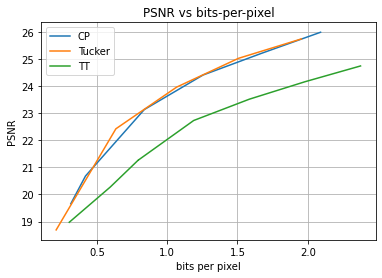

In [76]:
plot_rd_curve(curve_dict, "PSNR")

<AxesSubplot:title={'center':'MeanSquaredError vs bits-per-pixel'}, xlabel='bits per pixel', ylabel='MeanSquaredError'>

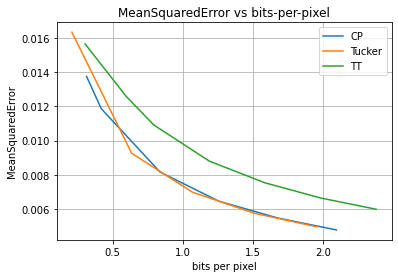

In [77]:
plot_rd_curve(curve_dict, "MeanSquaredError")

<AxesSubplot:title={'center':'MultiscaleStructuralSimilarity vs bits-per-pixel'}, xlabel='bits per pixel', ylabel='MS-SSIM (dB)'>

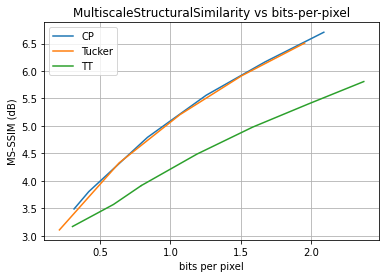

In [78]:
# Plotting MS-SSIM in dB as is done in the Scale Hyperprior paper.
plot_rd_curve(
    curve_dict, 
    "MultiscaleStructuralSimilarity", 
    y_transform = lambda d: -10*math.log10(1 - d), 
    y_label = "MS-SSIM (dB)"
)